# TensorBoard Scalars: Logging training metrics in Keras

## 0. Overview

## 1. Setup

In [1]:
# Load the TensorBoard notebook extension.
# pip install jupyter-tensorboard
%load_ext tensorboard

In [2]:
from datetime import datetime
from packaging import version

import tensorflow as tf
from tensorflow import keras

import numpy as np

print("TensorFlow version: {}".format(tf.__version__))

assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."

TensorFlow version: 2.4.1


## 2. Set up data for a simple regression

In [3]:
# First, generate 1000 data points roughly along the line y = 0.5x + 2. 
# Split these data points into training and test sets. 
# Your hope is that the neural net learns this relationship.


data_size = 1000
# 80% of the data is for training.
train_pct = 0.8

train_size = int(data_size * train_pct)

# Create some input data between -1 and 1 and randomize it.
x = np.linspace(-1, 1, data_size)
np.random.shuffle(x)

# Generate the output data.
# y = 0.5x + 2 + noise
y = 0.5 * x + 2 + np.random.normal(0, 0.05, (data_size, ))

# Split into test and train pairs.
x_train, y_train = x[:train_size], y[:train_size]
x_test, y_test = x[train_size:], y[train_size:]

## 3. Training the model and logging loss

In [4]:
logdir = "./logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

model = keras.models.Sequential([
    keras.layers.Dense(16, input_dim=1),
    keras.layers.Dense(1),
])

model.compile(
    loss='mse', # keras.losses.mean_squared_error
    optimizer=keras.optimizers.SGD(lr=0.2),
)

print("Training ... With default parameters, this takes less than 10 seconds.")
training_history = model.fit(
    x_train, # input
    y_train, # output
    batch_size=train_size,
    verbose=0, # Suppress chatty output; use Tensorboard instead
    epochs=100,
    validation_data=(x_test, y_test),
    callbacks=[tensorboard_callback],
)

print("Average test loss: ", np.average(training_history.history['loss']))

Training ... With default parameters, this takes less than 10 seconds.
Average test loss:  0.04266341667622328


## 4. Examining loss using TensorBoard

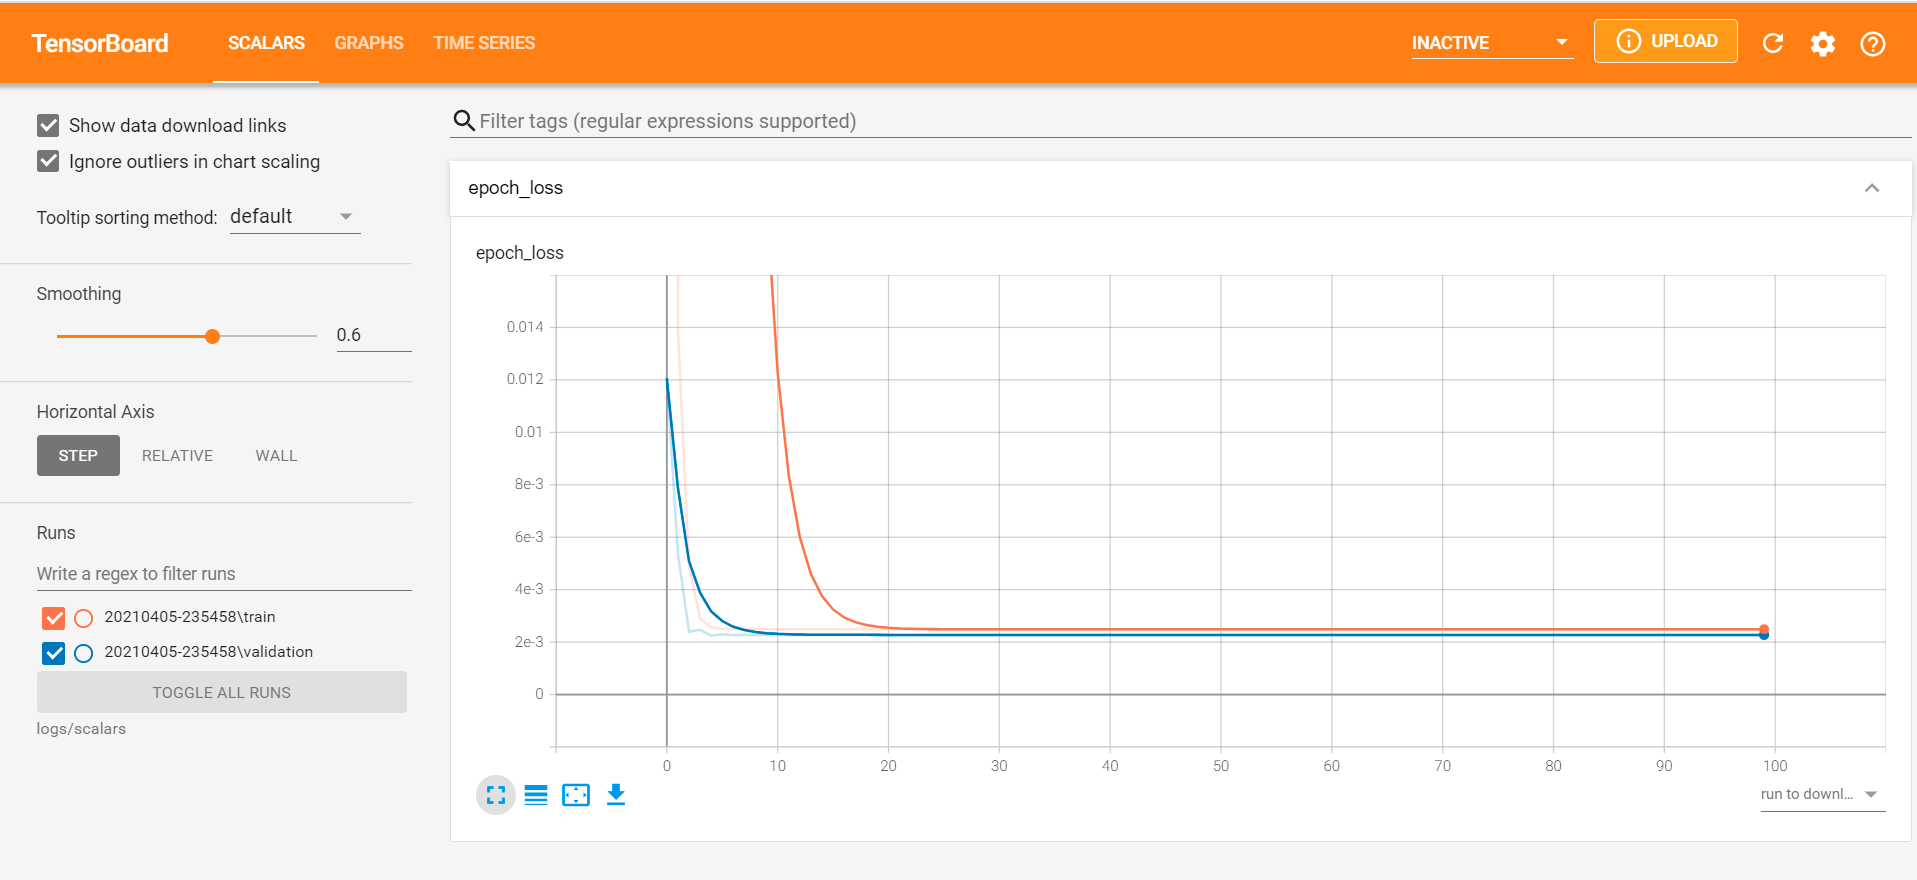

In [6]:
from IPython.display import Image, display
display(Image(filename="./image/scalars.png", embed=True))

In [7]:
# Given the input data (60, 25, 2), the line y = 0.5x + 2 should yield (32, 14.5, 3). Does the model agree?

print(model.predict([60, 25, 2]))
# True values to compare predictions against: 
# [[32.0]
#  [14.5]
#  [ 3.0]]

[[31.889914]
 [14.453784]
 [ 2.995756]]


## 5. Logging custom scalars

In [8]:
logdir = "./logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(logdir + "/metrics")
file_writer.set_as_default()

def lr_schedule(epoch):
  """
  Returns a custom learning rate that decreases as epochs progress.
  """
  learning_rate = 0.2
  if epoch > 10:
    learning_rate = 0.02
  if epoch > 20:
    learning_rate = 0.01
  if epoch > 50:
    learning_rate = 0.005

  tf.summary.scalar('learning rate', data=learning_rate, step=epoch)
  return learning_rate

lr_callback = keras.callbacks.LearningRateScheduler(lr_schedule)
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

model = keras.models.Sequential([
    keras.layers.Dense(16, input_dim=1),
    keras.layers.Dense(1),
])

model.compile(
    loss='mse', # keras.losses.mean_squared_error
    optimizer=keras.optimizers.SGD(),
)

training_history = model.fit(
    x_train, # input
    y_train, # output
    batch_size=train_size,
    verbose=0, # Suppress chatty output; use Tensorboard instead
    epochs=100,
    validation_data=(x_test, y_test),
    callbacks=[tensorboard_callback, lr_callback],
)

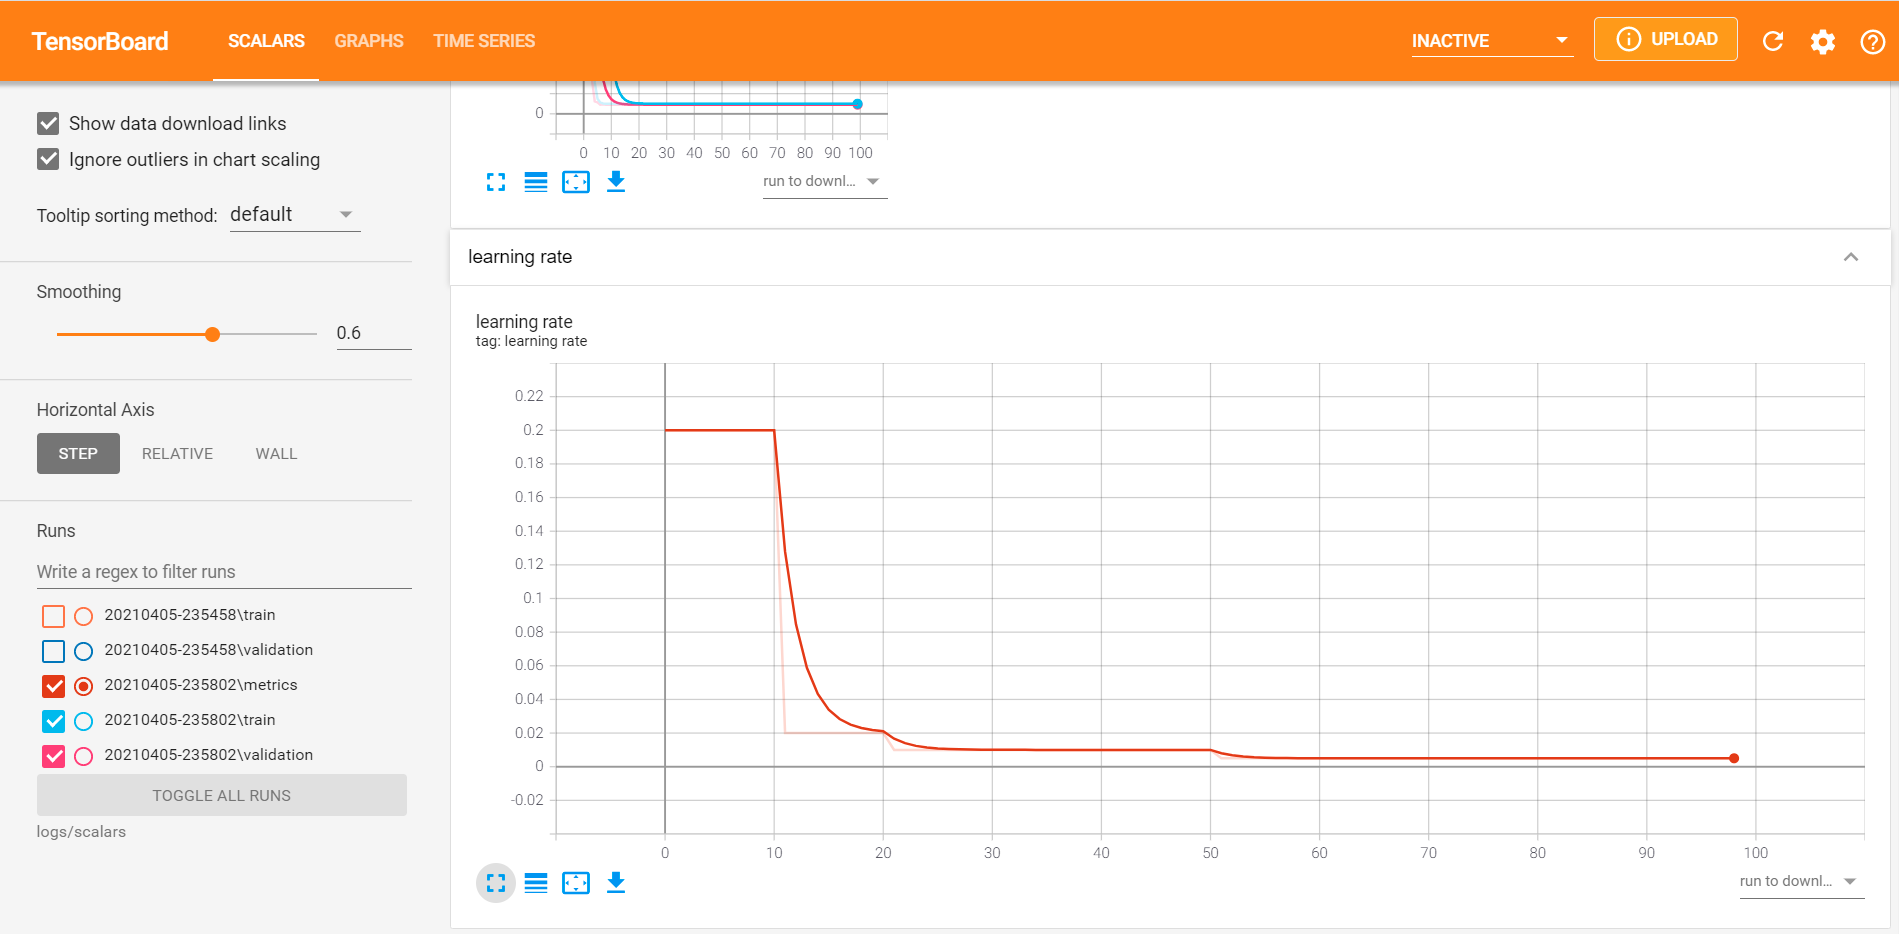

In [9]:
from IPython.display import Image, display
display(Image(filename="./image/scalars2.png", embed=True))

In [10]:
print(model.predict([60, 25, 2]))
# True values to compare predictions against: 
# [[32.0]
#  [14.5]
#  [ 3.0]]

[[31.883642 ]
 [14.451174 ]
 [ 2.9955497]]


# reference

### https://tensorflow.google.cn/tensorboard/scalars_and_keras